In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

from scipy.stats import skew
from collections import Counter

In [2]:
df = pd.read_csv("./data/subband_data.csv")
#df = pd.read_csv("./data/preprocessed/data.csv")
df = df.dropna()

In [4]:
data = df.to_numpy()
X = data[:,1:-1]
Y = data[:,-1]

#print(np.min(X))
assert(np.min(X) > 0)

X0 = X
X1 = np.log10(X0)
X0 = (X0-np.mean(X0, axis=0))/np.std(X0, axis=0)
X1 = (X1-np.mean(X1, axis=0))/np.std(X1, axis=0)

Nepochs, Nfeatures = X.shape
print(X.shape)

# reduce skew
X1_skew = skew(X1, axis=0)
X0_skew = skew(X0, axis=0)
skew_delta = np.abs(X0_skew)-np.abs(X1_skew)
skew_delta = skew_delta
#indices where we have non-beneficial log transform
bad_log_i = np.where(skew_delta < 0)
print(bad_log_i)

# # plot effect of log transform
# plt.figure()
# plt.scatter(np.arange(Nfeatures), skew_delta)
# plt.axhline(0, c="black", linestyle="--")
# plt.title("Skewness improvement with log transform")
# plt.show()

# i = np.argmax(np.abs(X1_skew))
# plt.figure()
# _ = plt.hist(X1[:,i], bins=100, label="Log transform")
# _ = plt.hist(X0[:,i], bins=100, label="Original")
# plt.legend()
# plt.title(f"Histogram of worst skewness after log transform - X{i}")
# plt.show()

# i = np.argmin(np.abs(X1_skew))
# plt.figure()
# _ = plt.hist(X1[:,i], bins=100, label="Log transform")
# _ = plt.hist(X0[:,i], bins=100, label="Original")
# plt.legend()
# plt.title(f"Histogram of best skewness after log transform - X{i}")
# plt.show()

# ignore log transform where it worsens skew
X1[:,bad_log_i] = X0[:,bad_log_i]
Y1 = Y

(97432, 22)
(array([12], dtype=int64),)


In [17]:
# split into training and testing
# with the training set, we want to rebalance using oversampling
Ntotal = X1.shape[0]
Ntrain = int(Ntotal*0.8)

idxs = np.arange(Ntotal)
np.random.shuffle(idxs)

Xtrain, Ytrain = X1[idxs[:Ntrain]], Y1[idxs[:Ntrain]]
Xtest, Ytest = X1[idxs[Ntrain:]], Y1[idxs[Ntrain:]]

#over_sampler = SMOTE()
#Xtrain, Ytrain = over_sampler.fit_resample(Xtrain, Ytrain)

print(Xtrain.shape)

(77945, 22)


In [78]:
clf = SVC()
clf.fit(Xtrain, Ytrain)

ypred = clf.predict(Xtrain)
train_acc = np.mean(ypred == Ytrain)
ypred = clf.predict(Xtest)
test_acc = np.mean(ypred == Ytest)
print(train_acc)
print(test_acc)

KeyboardInterrupt: 

In [15]:
clf = tree.DecisionTreeClassifier(max_depth=20, min_samples_split=100)
#clf = tree.DecisionTreeClassifier()
clf = clf.fit(Xtrain, Ytrain)

ypred = clf.predict(Xtrain)
train_acc = np.mean(ypred == Ytrain)
ypred = clf.predict(Xtest)
test_acc = np.mean(ypred == Ytest)

print(train_acc)
print(test_acc)

0.796116576669872
0.6907168881818648


In [18]:
clf = LogisticRegression(max_iter=1000)
#clf = tree.DecisionTreeClassifier()
clf = clf.fit(Xtrain, Ytrain)

ypred = clf.predict(Xtrain)
train_acc = np.mean(ypred == Ytrain)
ypred = clf.predict(Xtest)
test_acc = np.mean(ypred == Ytest)

print(train_acc)
print(test_acc)

0.7460901918019116
0.7488068969056294


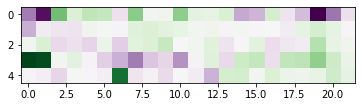

In [80]:
plt.imshow(clf.coef_, cmap="PRGn")
#plt.colorbar()

0.19077196095829635
0.61


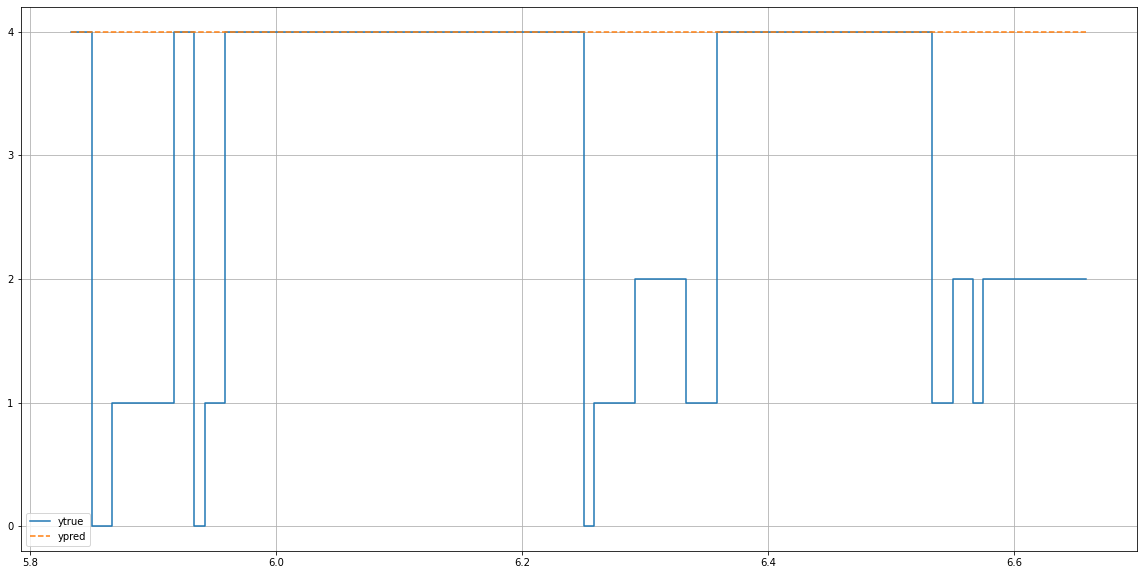

In [16]:
pid = 0
mask = (df['pid'] == pid)
x = X[mask]
y = Y[mask]

# Plot our true and predicted hypnogram
len_slice = 100
n_slice = 7
i = np.arange(0, len_slice) + len_slice*n_slice
#i = np.arange(0, y.shape[0])
epoch_time = 30
t = i*(epoch_time/3600) # hours

y_true = y
y_pred =  clf.predict(x)
print(np.mean(y_true == y_pred))
print(np.mean(y_true[i] == y_pred[i]))

fig = plt.figure(figsize=(20,10))
plt.step(t, y_true[i], label="ytrue")
plt.step(t, y_pred[i], linestyle="--", label="ypred")
_ = plt.yticks(np.unique(y))
plt.grid(True)
plt.legend()